# Nuberu experimental results

## Reading data

In [1]:
data_file = "https://github.com/asi-uniovi/nuberu-experiments-results/releases/download/v0.1.0/all_requests_data.parquet"

In [2]:
# Read parquet file
import pandas as pd
data = pd.read_parquet(data_file)
data['injected'] = pd.to_datetime(data['injected'], unit='s', origin='2025-06-24 09:00:00')

# Rename values in "LB" column
data['LB'] = data['LB'].replace({
    'smoothWRR': "SWRR",
    "simple": "RR"
})

# Apply a function to every value in the "experiment" column
data['experiment'] = data['experiment'].apply(lambda x: 
                                              x.replace("smoothWRR", "SWRR")
                                              .replace("simple", "RR")
)
                                              

## Summary of results



In [3]:
# Compute the percentage of finished requests for each app
percentage_pivot = data.pivot_table(
    index=['queue_size', 'termination', 'LB', 'distribution'],
    columns='app', values='finished', aggfunc=lambda x: x.sum() / len(x) * 100,
    fill_value=0).round(1)

# Append the cost of each experiment
cost_summary = data.groupby(['queue_size', 'termination', 'LB', 'distribution'])['cost'].first()
summary_with_cost = percentage_pivot.join(cost_summary)

summary_with_cost

app0   app1   cost
queue_size termination LB   distribution                     
0          drain       RR   poisson        82.6   95.0  10.66
                            trace         100.0   98.5  10.63
                       SWRR poisson        82.6   94.8  10.66
                            trace         100.0   94.4  10.63
           hard        RR   poisson        82.6   94.9  10.62
                            trace         100.0   98.5  10.62
                       SWRR poisson        82.6   94.8  10.62
                            trace         100.0   94.3  10.62
1000       drain       RR   poisson       100.0   99.8  16.56
                            trace         100.0   99.8  16.53
                       SWRR poisson       100.0  100.0  10.66
                            trace         100.0  100.0  10.63
           hard        RR   poisson       100.0   99.2  10.62
                            trace         100.0   99.2  10.62
                       SWRR poisson       100.0  100.0  10.62
                            trace         100.0  100.0  10.62

## Plots

In [4]:
import plotting_utils as pu
import importlib
importlib.reload(pu)
import matplotlib.pyplot as plt

## Injected workload plots

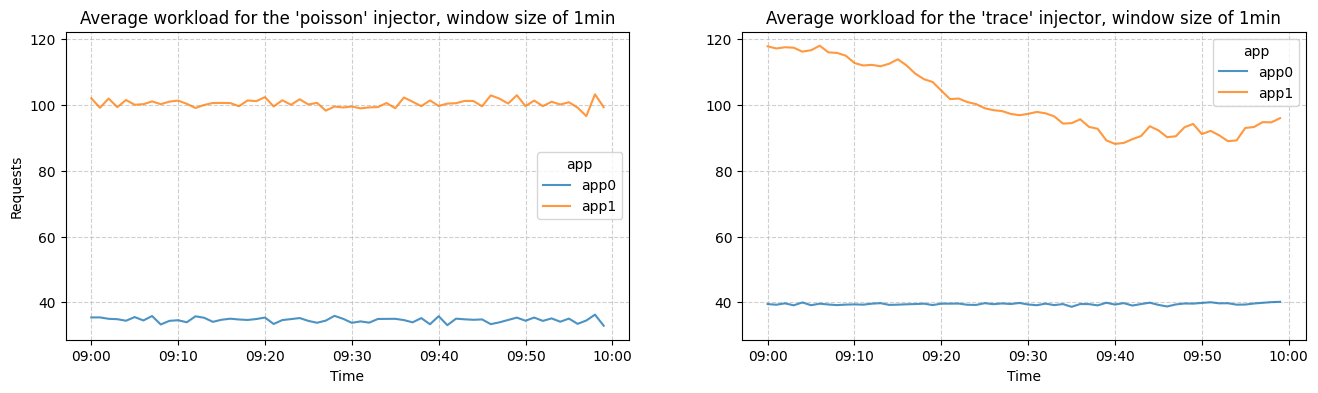

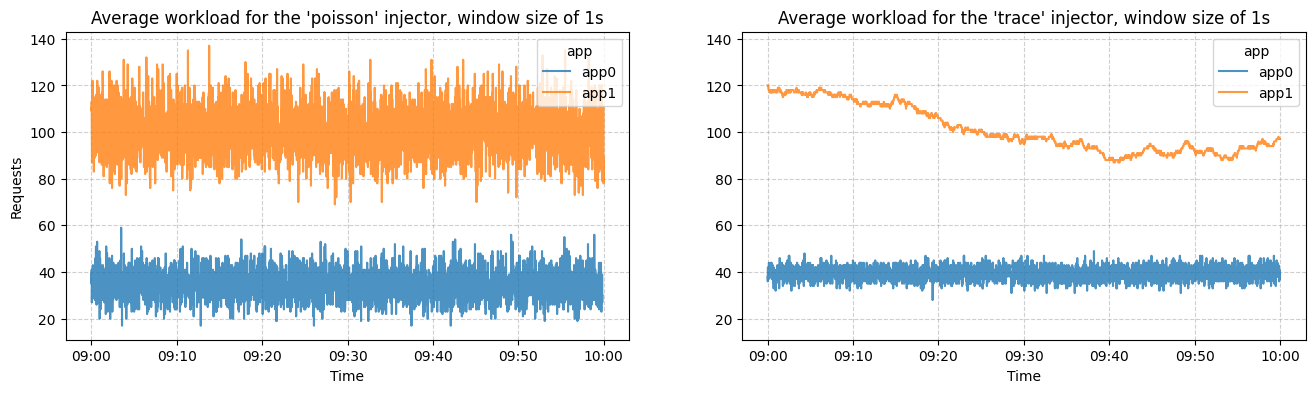

In [5]:
# Generate plots for injected requests in the two cases of injectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1min", ax=ax1)
pu.plot_workloads(data, "trace", "1min", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

# Generate also plots for 1s window
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1s", ax=ax1)
pu.plot_workloads(data, "trace", "1s", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

## Response time example plots

**Scenario 1, plot by apps**
- Trace based injector
- Drain pending requests at the end
- Smooth Weighted Round-Robin load balancer
- Queue size 1000

Plot of average response time (60s window) per app, with error bars

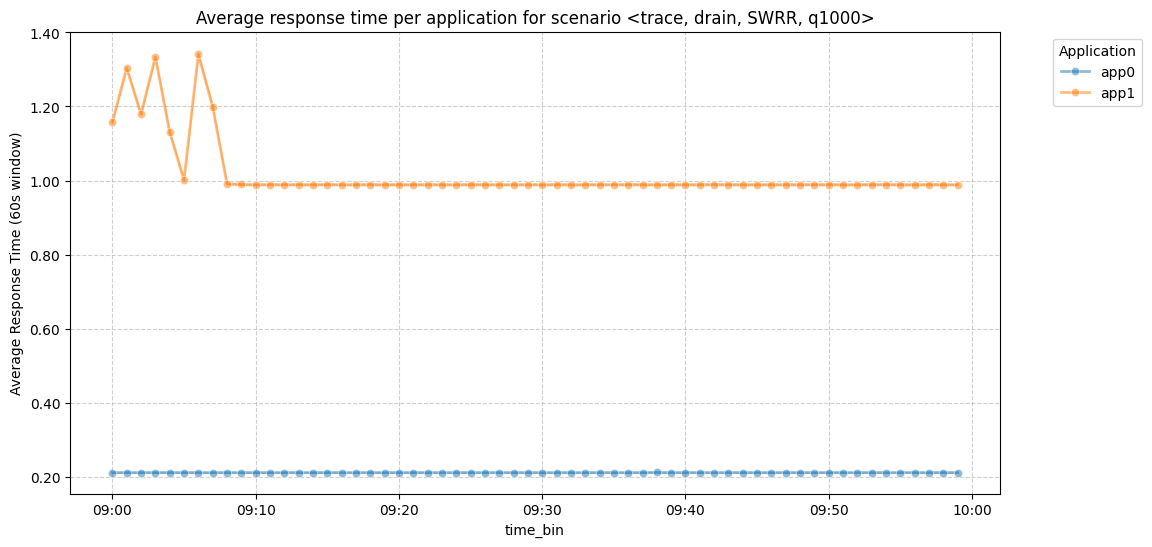

In [6]:
pu.plot_response_time(data, "trace", "drain", "SWRR", "q1000");

**Scenario 1, plot by containers for app1**

 - Trace based injector
 - Drain pending requests at the end
 - Smooth Weighted Round-Robin load balancer
 - Queue size 1000

Plot of response times per container for app1, with error bars. This plot is useful to detect possible saturation problems in the containers which have less performance, if the load balancing is not being done properly. In the scepario below, the SWRR is doing a good balance, which ensures that all container classes receive a workload proportional to its capacity. The particular workload in this case has several spikes during the first ten minutes, showing increased response times due to queueing, but then the response times stablize when the load peaks disappear. Containers of class cc0app1 are slower than those of class cc1app1.

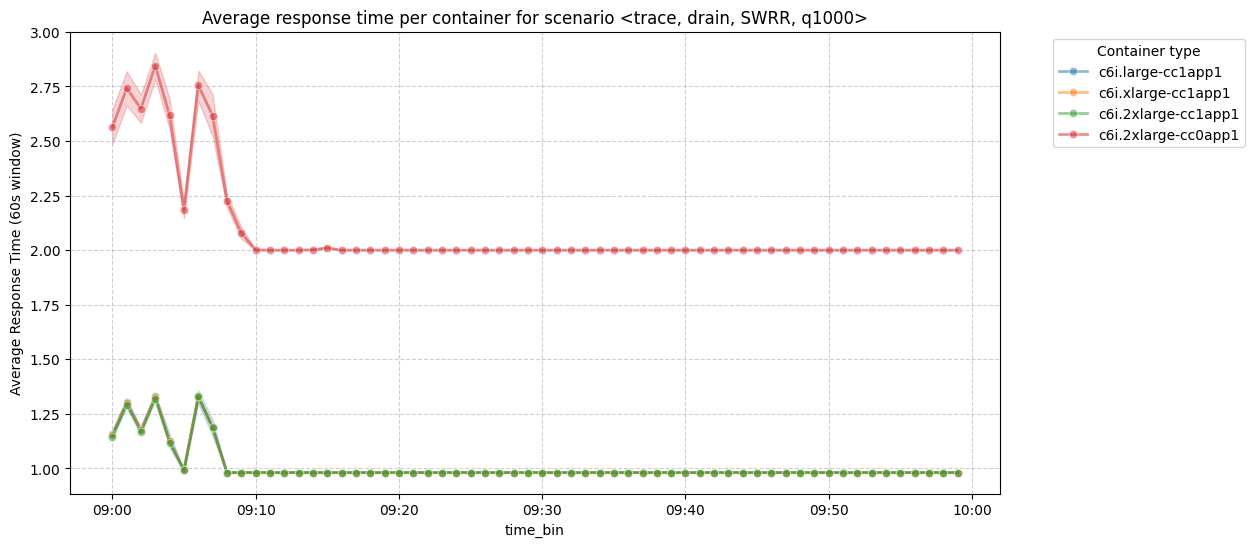

In [7]:
pu.plot_response_time(data, "trace", "drain", "SWRR", "q1000", app="app1", grouper="ic-cc");

**Scenario 2, plot by containers for app1**

 - Trace based injector
 - Drain pending requests at the end
 - Simple Round Robin load balancer
 - Queue size 1000

Plot of response times per container for app1, with error bars. This scenario reveals a problem with the simple RR load balancer (cf. with the previous one using SWRR). The containers of class cc0app1 are saturated, because RR treats all container classes as equal, but cc0app1 are slower. This causes the queue of these containers to grow until the maximum size (q=1000) is reached, and after that moment some requests to those containers will be rejected. Response times increase up to 2000s due to these queues. Also, the 'drain' termination strategy requires more time to empty these queues.

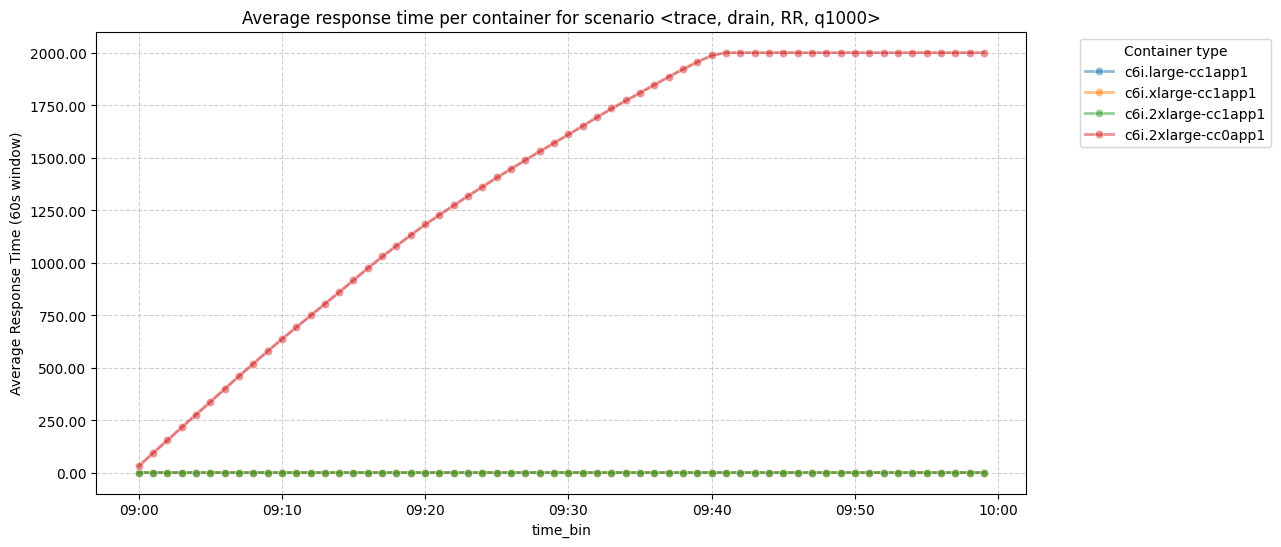

In [8]:
pu.plot_response_time(data, "trace", "drain", "RR", "q1000", app="app1", grouper="ic-cc");

## Completed vs lost requests

**Scenario 1**
- Trace based injector
- Drop pending requests at the end
- Smooth Weighted Round Robin load balancer
- Queue size 1000

Bar plot of completed and failed requests each 60s per app

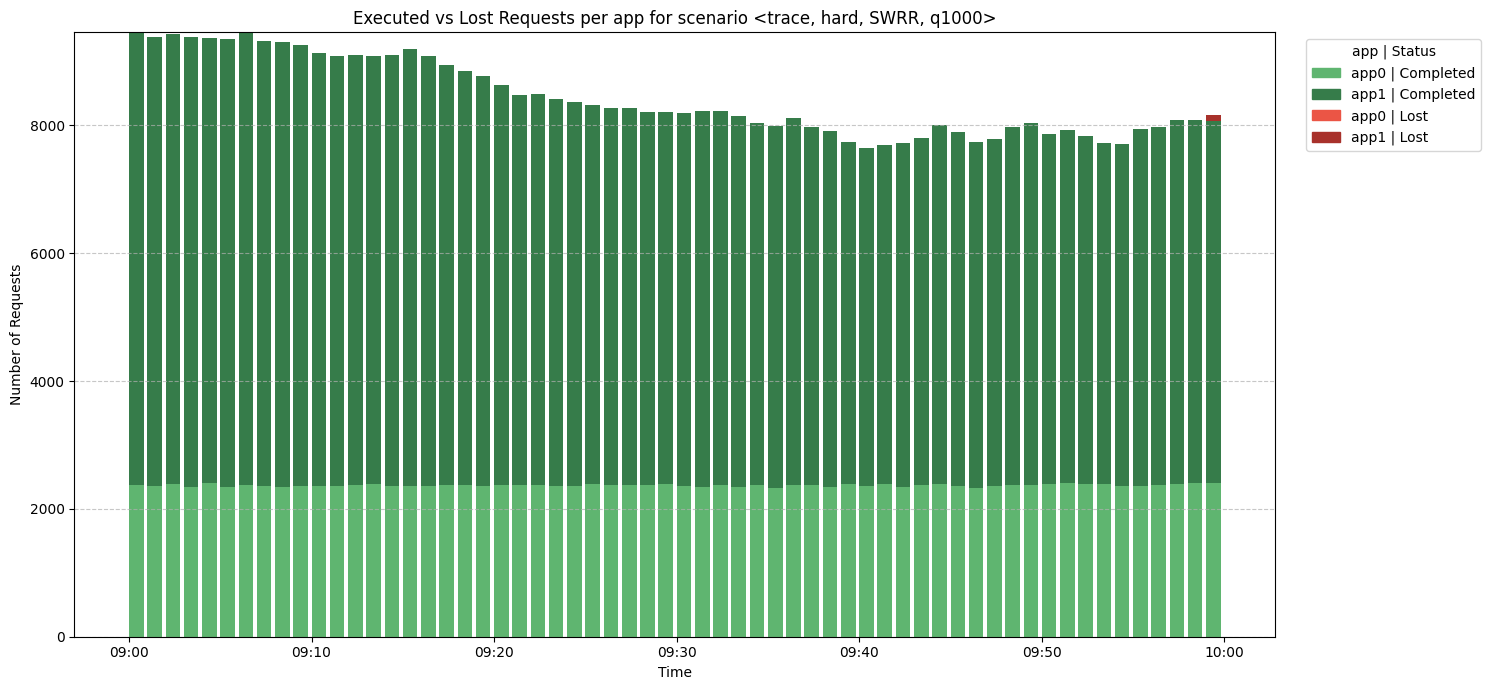

In [9]:
pu.plot_requests_success(data, "trace", "hard", "SWRR", "q1000");

The above scenario uses queues large enough to store pending requests, so no requests are rejected. However, at the end of the experiment, there were pending requests in the queues (specially for app1), causing lost requests (dropped) at the end.

**Scenario 2**
- Trace based injector
- Drain pending requests at the end
- Smooth Weighted Round Robin Load Balancer
- Queue size 0 (no queues)

Bar plot of completed and failed requests each 60s per app

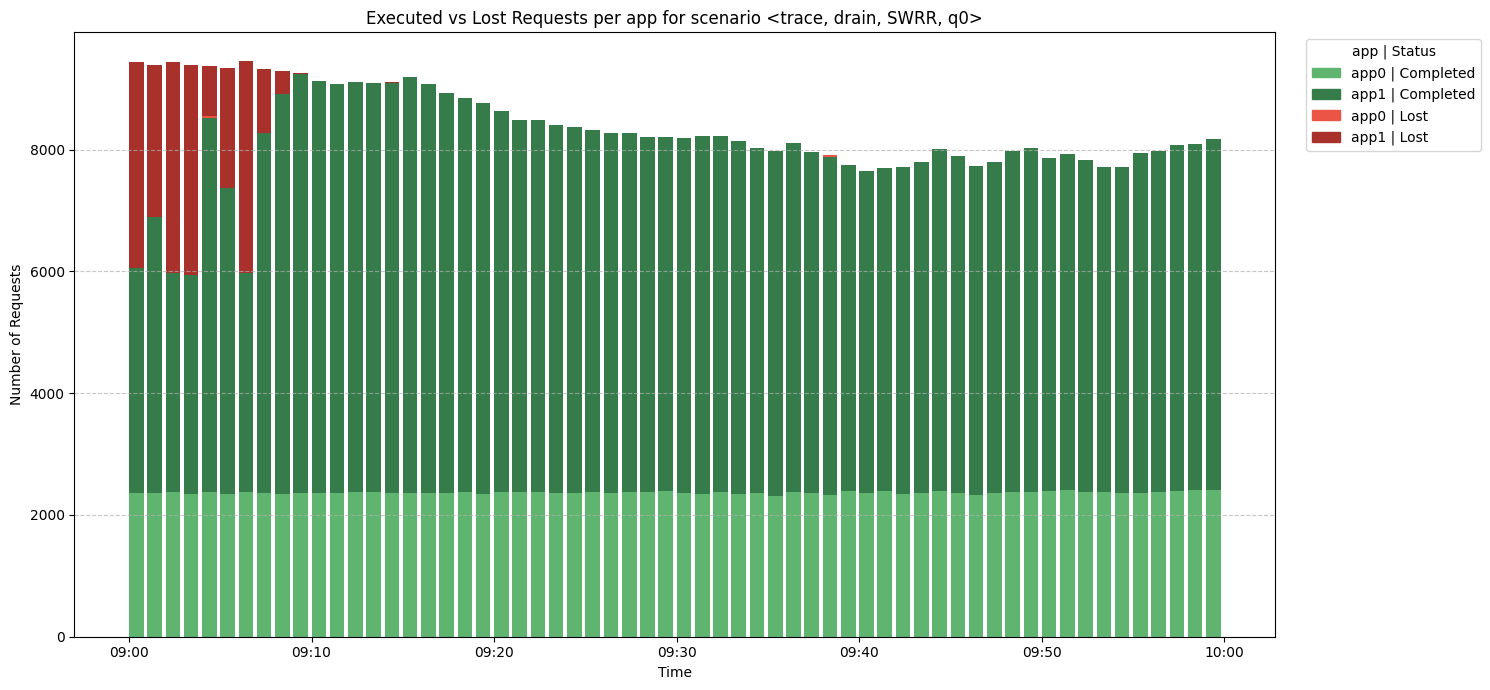

In [10]:
pu.plot_requests_success(data, "trace", "drain", "SWRR", "q0");

The above scenario does not use queues, so requests are rejected if they are delivered to a busy server. This causes a significant fraction of request to be dropped, especially for app1 at the beginning, since in that period of time the workload was larger than the p95 guaranteed by the allocation solver.

**Scenario 2 again, plot for app1 by container**
- Trace based injector
- Drain pending requests at the end
- Smooth Weighted Round Robin Load Balancer
- Queue size 0 (no queues)

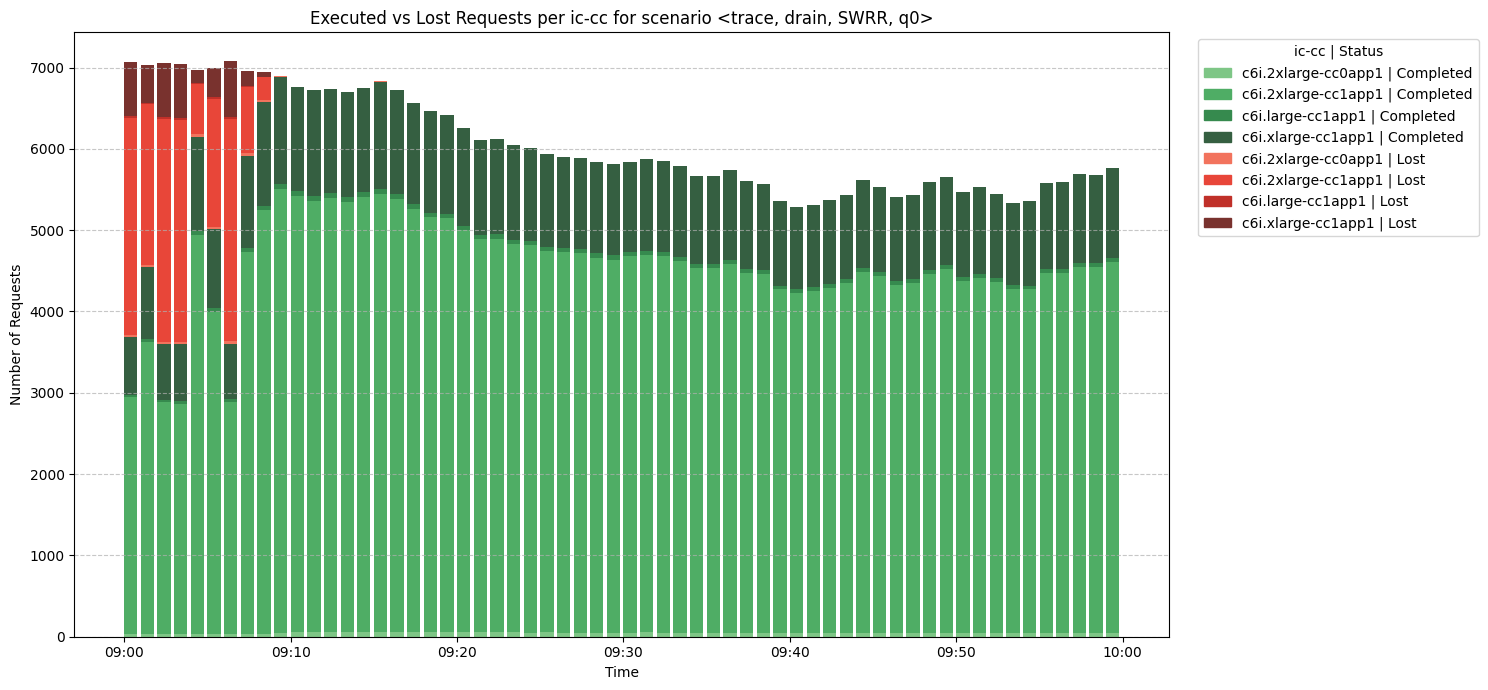

In [11]:
pu.plot_requests_success(data, "trace", "drain", "SWRR", "q0", app="app1", grouper="ic-cc");

**Scenario 3**
- Poisson based injector
- Drop pending requests at the end ('hard')
- Simple Round Robin Load Balancer
- Queue size 0 (no queues)

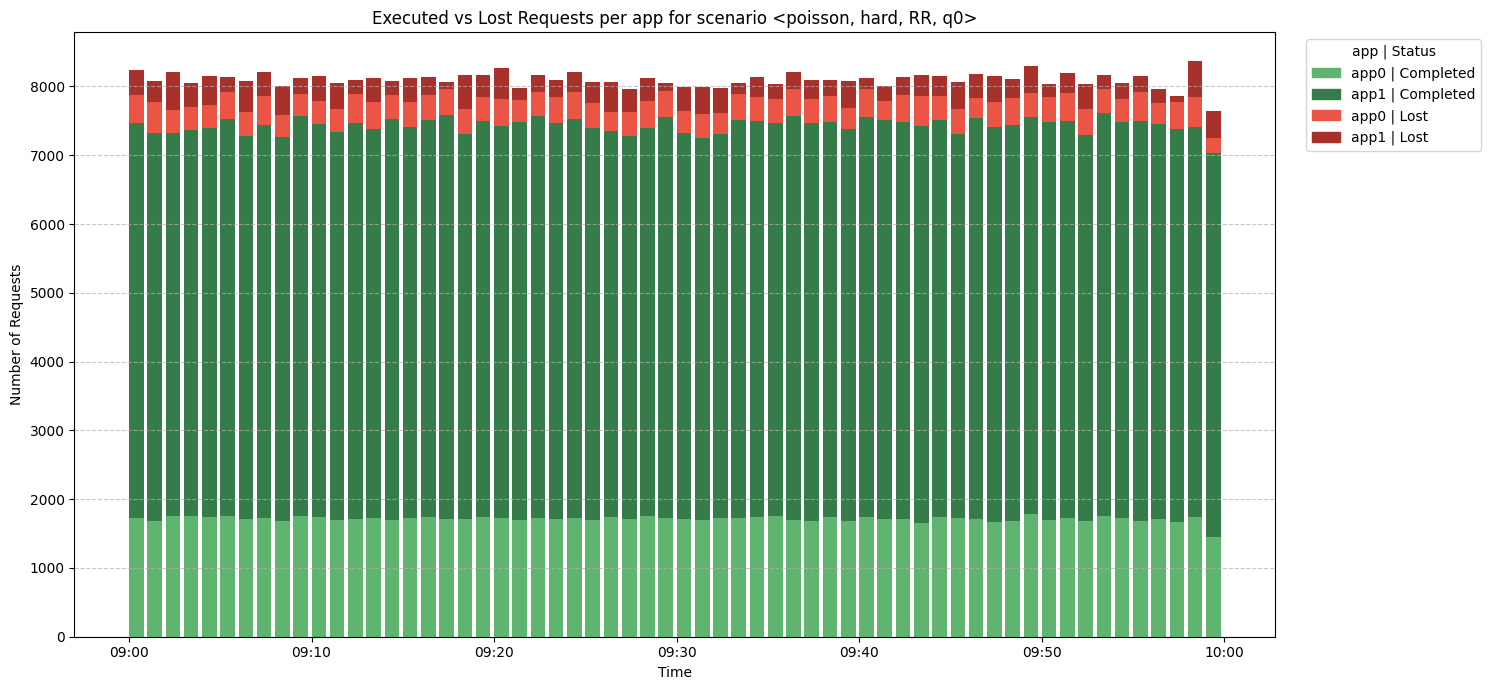

In [16]:
pu.plot_requests_success(data, "poisson", "hard", "RR", "q0");

This scenario uses a Poisson process to model the arrival of requests, instead of reading the actual number of request from a trace file.

The $\lambda$ values for the Poisson process were chosen to yield an average of 34.563 rps for app0 and 100.718 rps for app1. These values were selected so that the 95th percentile (p95) is 44 rps for app0 and 117 rps for app1, which are the values considered by the solver conlloovia.

As shown in the plot, some requests are rejected because they arrive to a busy server. Therefore, the optimal solution provided by conlloovia cannot sustain this arrival rate unless the requests are perfectly equispaced — which is not the case under a Poisson process.